# Import

In [1]:
# -------------------------
# 0) CONFIG 
# -------------------------
import os, sys

# --- Env vars expected by csiro.config (no defaults) ---
COMP_ROOT = "/notebooks/kaggle/csiro"
TRAIN_CSV = f"{COMP_ROOT}/train.csv"
TEST_CSV = f"{COMP_ROOT}/test.csv"

IMAGE_ROOT = COMP_ROOT
sub_id = "3"
OUTPUT_PATH = f"/notebooks/kaggle/csiro/sub/sub{sub_id}.csv"
BB_TEST = COPY_WEIGHTS = WRITE_SUB = False

CSIRO_CODE_DIR = "/notebooks/CSIRO"
DINO_REPO = CSIRO_CODE_DIR + "/_dinov3"
sys.path.insert(0, CSIRO_CODE_DIR)
sys.path.insert(0, DINO_REPO)

os.environ["DEFAULT_DINO_ROOT"] = DINO_REPO
os.environ["DEFAULT_DATA_ROOT"] = COMP_ROOT
os.environ["DINO_B_WEIGHTS_PATH"] = "/notebooks/kaggle/csiro/weights/dinov3/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth"
os.environ["DINO_L_WEIGHTS_PATH"] = "/notebooks/kaggle/csiro/weights/dinov3/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth"

# -------------------------
# 1) Imports
# -------------------------
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image
import shutil

import csiro
from csiro.config import TARGETS, dino_hub_name
from csiro.data import TiledSharedTTADataset, _maybe_preprocess_image
from csiro.eval import predict_ensemble_tiled, load_ensemble_states

# -------------------------
# 1) Params
# -------------------------
WEIGHTS_PATHS = [
    "/notebooks/kaggle/csiro/output/states/CSIRO_v20_noPool_cv2_cv_state.pt",
]

# Inference params
IMG_SIZE = 512
BATCH_SIZE = 16
NUM_WORKERS = 2
DEVICE = "cuda"  
MODEL_SIZE = "l"
DEFAULT_PLUS = ""
IMG_PREPROCESS = True

# TTA / ensemble knobs
TTA_N = 3
TTA_BCS = 0.1
TTA_HUE = 0.1
TTA_AGG = "mean"
INNER_AGG = "mean"
OUTER_AGG = "flatten"


if MODEL_SIZE == "b":
    DINO_WEIGHTS = os.getenv("DINO_B_WEIGHTS_PATH")
elif MODEL_SIZE == "l":
    DINO_WEIGHTS = os.getenv("DINO_L_WEIGHTS_PATH")
else:
    assert False

if COPY_WEIGHTS:
    src = DINO_WEIGHTS
    dst = f"/kaggle/working/{os.path.basename(DINO_WEIGHTS)}"
    shutil.copyfile(src, dst)
    DINO_WEIGHTS = dst


# Review transform

In [ ]:
from csiro.utils import preview_augments, build_color_jitter_sweep, load_train_dataset_simple
_, dataset = load_train_dataset_simple()

In [22]:
from csiro.utils import build_color_jitter_sweep

# 3-point sweep around your default (0.25, 0.25, 0.25, 0.035)
tfms_list = build_color_jitter_sweep(
    3,
    bcs_range=(0.2, 0.35),
    hue_range=(0.035, 0.1),
)

preview_augments(
    tfms_list,
    dataset=dataset[1],
    k=3,
    seed=0,
    show_titles=True,
)

NameError: name 'preview_augments' is not defined

# Eval review

In [ ]:
if BB_TEST:
    backbone = torch.hub.load(
        DINO_REPO,
        dino_hub_name(model_size=MODEL_SIZE, plus=str(DEFAULT_PLUS)),
        source="local",
        weights=DINO_WEIGHTS,
    ).cuda()

    backbone.rope_embed.rescale_coords = None

    for i in range(len(backbone.blocks)):
        assert backbone.blocks[i].sample_drop_ratio == 0
        
    for n, p in backbone.named_modules():
        if "drop" in n:
            assert float(p.p) == 0-0

    inp = torch.randn(1, 3, 512, 512).cuda()
    
    backbone.train()
    with torch.no_grad():
        x1 = backbone(inp)[0]
        x2 = backbone(inp)[0]
        
    print(torch.allclose(x1["x_postnorm"], x2["x_postnorm"]))
        
    backbone.eval()
    with torch.no_grad():
        x1 = backbone(inp)[0]
        x2 = backbone(inp)[0]
        
    print(torch.allclose(x1["x_postnorm"], x2["x_postnorm"]))
    assert not BB_TEST

False
True


In [2]:
# -------------------------
# 2) Load checkpoint + backbone
# -------------------------
states = load_ensemble_states(WEIGHTS_PATHS)
backbone = torch.hub.load(
    DINO_REPO,
    dino_hub_name(model_size=MODEL_SIZE, plus=str(DEFAULT_PLUS)),
    source="local",
    weights=DINO_WEIGHTS,
).cuda()
backbone.eval()

# -------------------------
# 3) Read train.csv (wide_df)
# -------------------------
from csiro.data import load_train_wide

wide_df = load_train_wide(TRAIN_CSV, root=COMP_ROOT)
IMAGE_PATH_COL = "image_path"
TARGET_NAME_COL = "target_name"
SAMPLE_ID_COL = "sample_id"

# Build long df view for convenience (same shape as raw train.csv)
df = wide_df.copy()


#df_img = df.drop_duplicates(subset=[IMAGE_PATH_COL]).reset_index(drop=True)
#print("rows_long:", len(df), "unique_images:", len(df_img))



# test data

In [3]:
# -------------------------
# 4) Dataset + inference
# -------------------------
from csiro.data import BiomassFullCached, TiledSharedTransformView

# Labeled base dataset (returns PIL + y)
ds_base = BiomassFullCached(
    wide_df,
    cache_images=False,
    img_preprocess=IMG_PREPROCESS,
)

# Deterministic eval view (no TTA dimension)
ds = TiledSharedTransformView(
    ds_base,
    geom_tfms=None,
    img_size=IMG_SIZE,
)



In [11]:
sd_path ="/notebooks/kaggle/csiro/output/states/CSIRO_v20_noPool_cv2_cv_state.pt"
import torch

state = torch.load(sd_path)

In [16]:
state["fold_model_scores"]

[[0.7200520634651184, 0.743245542049408, 0.7522132992744446],
 [0.7776366472244263, 0.7613773941993713, 0.7739927768707275],
 [0.8398525714874268, 0.8388647437095642, 0.7700711488723755]]

In [10]:
# Eval: replay fold ensemble score
from csiro.eval import eval_fold_ensemble_from_pt

pt_path = "/notebooks/kaggle/csiro/output/states/CSIRO_v20_noPool_cv2_cv_state.pt"
for i in range(6):
    # Example usage
    try:
        results = eval_fold_ensemble_from_pt(
            pt_path=pt_path,
            fold_idx=i,
            dataset=ds,
            backbone=backbone,
            wide_df=df,
            cv_cfg=2,
            batch_size=BATCH_SIZE,
            inner_agg=INNER_AGG,
            tta_agg=TTA_AGG,
        )
        print(results)
    except Exception as e:
        print(e)


[{'run_idx': 0, 'fold_idx': 0, 'n_models': 3, 'per_model_scores': [0.7149139642715454, 0.7243577241897583, 0.7579962015151978], 'ensemble_score': 0.7448190450668335}]
[{'run_idx': 0, 'fold_idx': 1, 'n_models': 3, 'per_model_scores': [0.7398039102554321, 0.7267219424247742, 0.7379381656646729], 'ensemble_score': 0.7519531846046448}]
[{'run_idx': 0, 'fold_idx': 2, 'n_models': 3, 'per_model_scores': [0.8208684921264648, 0.8365305662155151, 0.7871720194816589], 'ensemble_score': 0.8433529734611511}]
Missing fold 3 in checkpoint states.
Missing fold 4 in checkpoint states.
Fold 5 not found in CV iterator.


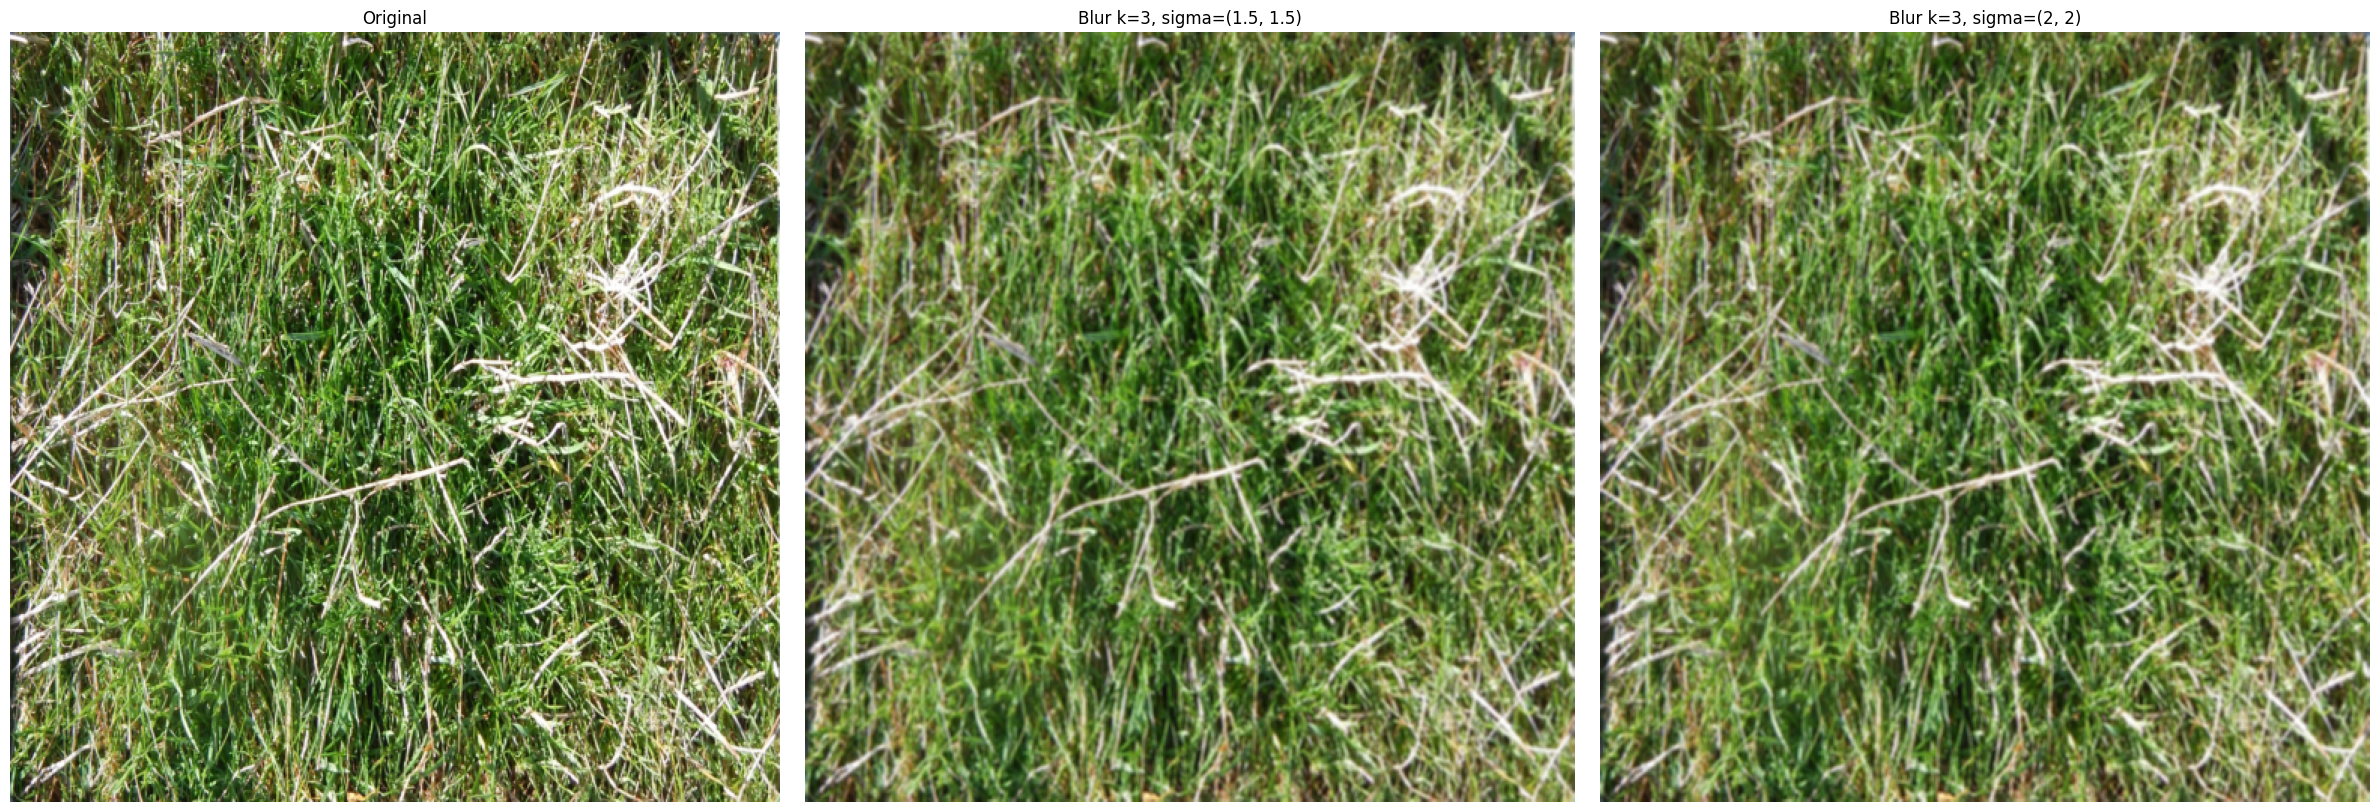

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T

def show_blur_grid(img_path, *, img_size=512,
                   k1=3, s1=(0.1, 0.7),
                   k2=5, s2=(0.2, 0.8),
                   k =2):
    img = Image.open(img_path).convert("RGB")
    resize = T.Resize((img_size, img_size), antialias=True)
    img_resized = resize(img)

    blur1 = T.GaussianBlur(kernel_size=k1, sigma=s1)(img_resized)
    blur2 = T.GaussianBlur(kernel_size=k2, sigma=s2)(img_resized)

    fig, axes = plt.subplots(1, 3, figsize=(12 * k, 4 * k))
    axes[0].imshow(img_resized)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(blur1)
    axes[1].set_title(f"Blur k={k1}, sigma={s1}")
    axes[1].axis("off")

    axes[2].imshow(blur2)
    axes[2].set_title(f"Blur k={k2}, sigma={s2}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

show_blur_grid("/notebooks/kaggle/csiro/train/ID1028611175.jpg",
               img_size=512,
               k1=3, s1=(1.5, 1.5),
               k2=3, s2=(2, 2))
